### Load libraries 




In [1]:
import pandas as pd
from IPython import display

import os 
import sys

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.__version__

'1.1.4'

In [3]:
#!pwd
print(os.getcwd())

D:\Documents\Education\University\4th Year\ELEC6200 - Group Design Project\gdp-wild-dogs


### Checking OS system 
- slight difference in file path for different OS systems:
    - linux: '/home/user/Data'
    - windows: 'C:\\user\\Data'

In [4]:
os_system = sys.platform
if os_system.startswith('win'):
    os_system = 'windows'
print('OS System: ', os_system)

OS System:  windows


### List Directory Tree

In [5]:
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

In [6]:
list_files(os.path.join(os.getcwd(), 'Data'))

Data/
    2020-11-05/
        201105_807d3a2a0fe8_xyz.pkl
        cut.pkl
        cutoff.txt
        dataFeatured.pkl
        labelled.pkl
        labels.csv
        raw.pkl
    2020-11-16/
        201116_807d3a2a0fe8_xyz.pkl
        cut.pkl
        cutoff.txt
        dataFeatured.pkl
        labelled.pkl
        labels.csv
        raw.pkl
    2020-11-23/
        201123_807d3a2a0fe8_xyz.pkl
        cut.pkl
        cutoff.txt
        dataFeatured.pkl
        labelled.pkl
        labels.csv
        raw.pkl
    2020-11-26/
        201126_807d3a2a0fe8_xyz.pkl
        cut.pkl
        cutoff.txt
        dataFeatured.pkl
        labelled.pkl
        labels.csv
        raw.pkl
    2020-11-27/
        201127_807d3a2a0fe8_xyz.pkl
        cut.pkl
        cutoff.txt
        dataFeatured.pkl
        labelled.pkl
        labels.csv
        raw.pkl
    2020-11-28/
        201128_807d3a2a0fe8_xyz.pkl
        raw.pkl
    2020-12-03/
        201203_807d3a2a0fe8.pkl
        201203_807d3a2a0fe8_xyz.pkl
  

 ### Loading pkl files into DFs

In [7]:
dfList=[]
csvDFList=[]

# Directories are according to git's file structure 
# [Linux] ./gdp-wild-dogs/Data/
if os_system == 'linux':
    filepath = './Data'
    pathstyle = '/'
elif os_system == 'windows':
    filepath = 'Data'
    pathstyle = '\\'

extended_label_dfList = []

#Store pkl from each day in df in list
for subdir, dirs, files in os.walk(filepath):
    if "extended_data.pkl" in os.listdir(subdir):
        df = pd.read_pickle(subdir+pathstyle+"extended_data.pkl")
        df.reset_index(inplace=True)
        extended_label_dfList.append(df)
    else:
        for filename in os.listdir(subdir):
            if filename == "cut.pkl":
                df = pd.read_pickle(subdir+pathstyle+ filename)
                df.reset_index(inplace=True)
                dfList.append(df)
            if filename == "labels.csv":
                df = pd.read_csv(subdir+pathstyle+filename)
                df.reset_index(inplace=True)
                csvDFList.append(df)
print("Number of unlabelled data files:")
print(len(dfList))
print("Number of labelled, extended data files:")
print(len(extended_label_dfList))

Number of unlabelled data files:
0
Number of labelled, extended data files:
5


In [8]:
for df in dfList:
    if(len(df["dt"]) > 0):
        print(str(df["dt"][0])[0:10])
        display.display(df.describe())

In [9]:
#Remove all over redundant data for testing
# REMOVE ON FURTHER DEVELOPMENT!
dfList = dfList[0:len(csvDFList)]
print(str(len(dfList)) + " Data sets loaded" )

0 Data sets loaded


In [10]:
for df in csvDFList:
    df.describe()
    print(str(df["start_time"][0])[0:10] + " Labels Loaded")
    print(df.head())
    print()

for df in dfList:
    if(len(df["dt"]) > 0):
        print(str(df["dt"][0])[0:10] + " Clipped Device Data Loaded")
        print(df.head())
        print()

In [11]:
query_variables = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]
# windowSize = Maximum Size of window on either side of point
def add_mean_var_variables(dfList, query_variables, windowSize=10, show_progress=False):
    dfIndex = 0
    composite_variables = []
    for df in dfList:
        print("Starting DF " + str(dfIndex))
        values = {}
        for variable in query_variables:
                values[variable + "_MEAN"] = []
                values[variable + "_VAR"] = []
        for i in range(0, len(df.index)):
            minIndex = 0
            maxIndex = len(df.index)
            if(i >= windowSize):
                minIndex = i - windowSize
            if(i <= len(df.index)-1-windowSize):
                maxIndex = i+windowSize
            slice = df.iloc[minIndex:maxIndex+1]
            for variable in query_variables:
                values[variable + "_MEAN"].append(slice[variable].mean())
                values[variable + "_VAR"].append(slice[variable].var())
            if(show_progress):
                display.clear_output()
                print("Processing Dataframe: " + str(dfIndex))
                print("Percentage Finished: " + str(float(i)*100/len(df.index)) + "%")
        for variable in query_variables:
                df[variable + "_MEAN"] = values[variable + "_MEAN"]
                df[variable + "_VAR"] = values[variable + "_VAR"]
                if(not (variable + "_MEAN") in composite_variables):
                    composite_variables.append((variable + "_MEAN"))
                if(not (variable + "_VAR") in composite_variables):
                    composite_variables.append((variable + "_VAR"))
        dfIndex += 1
    return composite_variables

composite_variables = add_mean_var_variables(dfList, query_variables)
print(composite_variables)

[]


In [12]:
def label_data(dfList, csvDFList):
    labelledDFList = []
    for dfIndex in range(0, len(dfList)):
        labels = []
        df = dfList[dfIndex]
        if('activity' in df.columns):
            df.drop('activity', 1, inplace=True)
        labelledDFList.append(df)
        csv = csvDFList[dfIndex]
        intervalIndex = 0
        intervalBegin = pd.to_datetime(csv['start_time'][intervalIndex], utc=True)
        intervalEnd = pd.to_datetime(csv['end_time'][intervalIndex], utc=True)
        for i in range(0, len(df)):
            time = pd.to_datetime(df['dt'][i])
            while(time > intervalEnd):
                if(intervalIndex + 1 >= len(csv)):
                    break
                intervalIndex += 1
                intervalBegin = pd.to_datetime(csv['start_time'][intervalIndex], utc=True)
                intervalEnd = pd.to_datetime(csv['end_time'][intervalIndex], utc=True)
            if(time > intervalEnd or time < intervalBegin):
                labels.append("None")
            else:
                labels.append(csv["activity"][intervalIndex])
        labelledDFList[dfIndex]["activity"] = labels
    return labelledDFList

labelledDFList = label_data(dfList, csvDFList)

In [13]:
#sns.set()

#sns.catplot(x="activity", y="acc_x", data=labelledDFList[0], aspect = 2.5)
#sns.catplot(x="activity", y="acc_y", data=labelledDFList[0], aspect = 2.5)
#sns.catplot(x="activity", y="acc_z", data=labelledDFList[0], aspect = 2.5)
#sns.catplot(x="activity", y="gyro_x", data=labelledDFList[0], aspect = 2.5)
#sns.catplot(x="activity", y="gyro_y", data=labelledDFList[0], aspect = 2.5)
#sns.catplot(x="activity", y="gyro_z", data=labelledDFList[0], aspect = 2.5)

In [14]:
#Format Time to Millis and Adding Variance / Mean

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import numpy as np

In [15]:
for i in range(0, len(dfList)):
    sessionMillis = []
    minMillis = pd.to_datetime(dfList[i]['dt'].min())
    for date in dfList[i]["dt"]:
        sessionMillis.append((pd.to_datetime(date)-minMillis) / timedelta(milliseconds=1))
    dfList[i]["deltaMillis"] = sessionMillis

In [16]:
labelledDFList = label_data(dfList, csvDFList)

#variables = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'acc_x_MEAN', 'acc_x_VAR', 'acc_y_MEAN', 'acc_y_VAR', 'acc_z_MEAN', 'acc_z_VAR', 'gyro_x_MEAN', 'gyro_x_VAR', 'gyro_y_MEAN', 'gyro_y_VAR', 'gyro_z_MEAN', 'gyro_z_VAR']
variables = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

if(labelledDFList != []):
    for variable in variables:
        sns.catplot(x="activity", y=variable, data=pd.concat(labelledDFList), aspect = 2.5)

In [17]:
def add_reciprocal_column(df, column1, column2, dfIndex, log=False, verbose=False):
    count = 0
    if(column1 in df.columns and column2 in df.columns):
        print("Forming reciprocal of " + column1 + "/" + column2)
        reciprocal_vals = []
        if((column1 + "/" + column2) in df.columns):
            df.drop(column1 + "/" + column2, 1, inplace=True)
        
        new_df = df
        for i in range(len(df)):
            x = df[column1][i]
            y = df[column2][i]
            if(x == 0):
                x = 0.00001
            if(y == 0):
                y = 0.00001
            
            result = x/y
            if(np.isnan(result) or np.isinf(result)):
                count += 1
                result = 0.00001
            if(log):
                result = np.log10(np.abs(result))
            reciprocal_vals.append(result)
            
            if(verbose):
                display.clear_output()
                print("Forming reciprocal of " + column1 + "/" + column2 + " for Dataframe " + str(dfIndex))
                print("Percentage Finished: " + str(float(i)*100/len(df)) + "%")
                print("NaN or Inf results: " + str(count))
        new_df[column1 + "/" + column2] = reciprocal_vals
        
        return new_df
    else:
        print("Columns not present in Dataframe. Cannot form Reciprocal!")

In [18]:
for i in range(0,len(labelledDFList)):
    labelledDFList[i] = add_reciprocal_column(labelledDFList[i], "acc_x", "acc_y", i, log=True)
for i in range(0,len(labelledDFList)):
    labelledDFList[i] = add_reciprocal_column(labelledDFList[i], "acc_x", "acc_z", i, log=True)
for i in range(0,len(labelledDFList)):
    labelledDFList[i] = add_reciprocal_column(labelledDFList[i], "acc_y", "acc_z", i, log=True)

In [19]:
from skimage import util

# M = Window Size, Rate in Hz
def calculate_fourier(column, df, rate, label, use_label=False, M = 64, freq_limit=-1, show=False):
    if(column in df.columns):
        data = np.array(df[column])
        if(use_label):
            data = np.array(df.loc[df['activity'] == label][column])
        N = data.shape[0]
        if(N <= M):
            if(use_label):
                print("Insufficient Data for activity: " + label)
            else:
                print("Insufficient Complete Data")
            return []
        L = N / rate
        slices = util.view_as_windows(data, window_shape=(M,), step=1)
        slices = slices * np.hanning(M + 1)[:-1]
        slices = slices.T
        spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
        spectrum = np.abs(spectrum)
        

        S = np.abs(spectrum)
        #S = 20 * np.log10(S / np.max(S))
        S = S / np.max(S)

        if(show):
            f, ax = plt.subplots(figsize=(20, 10))
            if(freq_limit != -1):
                ax.imshow(S[0:freq_limit], origin='lower', cmap='viridis', extent=(0, L, 0, freq_limit))
            else:
                ax.imshow(S, origin='lower', cmap='viridis', extent=(0, L, 0, np.max(np.fft.fftfreq(M, d=1/rate))))
            ax.axis('tight')
            y_label = 'Frequency [Hz] of value: '
            y_label = y_label + column
            ax.set_ylabel(y_label)
            ax.set_xlabel(label + ' Time [s]');
        #S has first index referencing frequency in Hz, second index is window index
        #print(L)
        return S

labels_of_interest = ['jumping', 'galloping', 'sitting', 'barking', 'trotting', 'walking', 'laying', 'sniffing', 'playing', 'standing', 'eating', 'sleeping', 'hunting']
#labels_of_interest = ['sitting', 'laying', 'standing', 'eating', 'sleeping']
value = "acc_y/acc_z"
do_log=False
freq_limit = 15
#plot_fourier(value, labelledDFList[1], 50, "Overall", use_label=False, M=80)
if(labelledDFList != []):
    for label in labels_of_interest:
        calculate_fourier(value, pd.concat(labelledDFList), 50, label, use_label=True, M=80, show=True)

In [20]:
def plot_values(df, column, label='', reciprocal=False, log=False, absolute=False):
    if(column in df.columns):
        values = df[column]
        if(label != ''):
            values = df.loc[df['activity'] == label][column]
        if(reciprocal):
            values = 1 / values
        if(log):
            values = np.log10(np.abs(values))
        if(absolute):
            values = np.abs(values)
        #values = np.clip(values, -100, 80)
        f, ax = plt.subplots(figsize=(20, 10))
        ax.plot(np.linspace(0, len(values), num=len(values)),values)
        #ax.axis('tight')
        ax.set_ylabel(column + " value for " + label)
        ax.set_xlabel(label + ' Time [20ms]');
        
    else:
        print(column + " is not present in this dataframe")
        return

In [21]:
index = 0
"""
plot_values(labelledDFList[index], "acc_x", label='galloping', reciprocal=False, log=False)
plot_values(labelledDFList[index], "acc_y", label='galloping', reciprocal=False, log=False)
plot_values(labelledDFList[index], "acc_z", label='galloping', reciprocal=False, log=False)
plot_values(labelledDFList[index], "gyro_x", label='galloping', reciprocal=False, log=False)
plot_values(labelledDFList[index], "gyro_y", label='galloping', reciprocal=False, log=False)
plot_values(labelledDFList[index], "gyro_z", label='galloping', reciprocal=False, log=False)

plot_values(labelledDFList[index], "acc_x/acc_y", label='galloping', reciprocal=False, log=True)
plot_values(labelledDFList[index], "acc_x/acc_z", label='galloping', reciprocal=False, log=True)
plot_values(labelledDFList[index], "acc_y/acc_z", label='galloping', reciprocal=False, log=True)
"""
labels_of_interest = ['sitting', 'laying', 'standing', 'eating', 'galloping', 'trotting']
value = "acc_z"
do_log=False
do_abs = True
if(labelledDFList != []):
    for label in labels_of_interest:
        plot_values(pd.concat(labelledDFList), value, label=label, reciprocal=False, log=do_log, absolute=do_abs)

In [22]:
def plot_corr_matrix(data, independent_variables):
    dummyDF = pd.get_dummies(pd.concat(labelledDFList))
    dummy_variables = [x for x in dummyDF.columns if x not in data.columns]
    corr_matrix = dummyDF.corr()
    plt.rcParams['figure.figsize'] = (20.0, 0.6*len(independent_variables))
    sns.heatmap(corr_matrix.loc[independent_variables][dummy_variables], annot=True)
    plt.show()

In [23]:
useful_frequencies = {'acc_x': [0, 2, 3, 4, 5, 7], 'acc_y': [0, 4, 5], 'acc_z': [0, 2, 3, 4, 5], 'gyro_x': [5], 'gyro_y': [3, 4], 'acc_x/acc_y': [0, 2, 3, 4], 'acc_x/acc_z': [5], 'acc_y/acc_z': [0, 2, 3]}

In [24]:
def add_fourier_variables(variable_frequencies, labelledDFList, window_size):
    fourier_variables = []
    for df in labelledDFList:
        for variable in variable_frequencies:
            frequency_indices = variable_frequencies[variable]
            S = calculate_fourier(variable, df, 50, '', use_label=False, M=window_size, show=False)
            for frequency_index in frequency_indices:
                new_column = []
                new_column.extend(np.zeros(window_size-1))
                new_column.extend(S[frequency_index])
                print(variable + " at frequency index: " + str(frequency_index))
                new_var_name = variable + "_freq_" + str(frequency_index)
                if(new_var_name in df.columns):
                    df.drop(new_var_name, 1, inplace=True)
                df[new_var_name] = new_column
                if(not new_var_name in fourier_variables):
                    fourier_variables.append(new_var_name)
    return fourier_variables

In [25]:
if(labelledDFList != []):
    fourier_vars = add_fourier_variables(useful_frequencies, labelledDFList, 80)
    print(fourier_vars)

In [26]:
from skimage import util
import pywt

cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
useful_wavelet_frequencies = {'acc_x': [14, 43, 62], 'acc_y': [48, 15], 'acc_z': [45], 'gyro_x': [12, 45, 62], 'gyro_y': [18], 'gyro_z': [48]}

def sampling(labelledDFList, N=80):
    # Every N data points (1.6s)
    
    list_np_X = list()
    list_np_Y = list()
    for i, df in enumerate(labelledDFList):
        
        IMU_data = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
        
        Y_N = np.array(df['activity'])
        Y_N = Y_N.reshape(len(Y_N), 1)
        print(Y_N.shape)

        #Values of ind. variables for all data points
        X_N = df[IMU_data].to_numpy()

        XY_N = np.concatenate((X_N, Y_N), axis=1)

        window_X = util.view_as_windows(XY_N, window_shape=(N,7), step=1)
        window_X = np.array([x[0] for x in window_X])


        X_N = window_X[:,:,np.arange(len(IMU_data))]
        print(X_N.shape)
        Y_N = window_X[:,:,-1]
        print(Y_N.shape)
        Y_N = np.array([i[0] for i in Y_N])
        
        list_np_X.append(X_N)
        list_np_Y.append(Y_N)
    
    dataX = np.concatenate(list_np_X, axis=0)
    dataY = np.concatenate(list_np_Y, axis=0)
    
    return dataX, dataY

# Wavelet Transforms 
def cwt_coeffs(X, column_indices=[], n_scales=64, wavelet_name='morl'):
    
    scales = np.arange(1, n_scales + 1)
    
    X_cwt = []
    variable_columns = []
    if(column_indices == []):
        variable_columns = range(X.shape[2])
    else:
        variable_columns = column_indices
    for signal in variable_columns:
        print('Column: ', cols[signal])
        
        coeffs_list = list()
        percentCompleted = 0
        for sample in range(X.shape[0]):
            if(sample*100/X.shape[0] > percentCompleted + 10):
                print(str(percentCompleted+10) + "% Completed")
                percentCompleted += 10
            coeffs, freqs = pywt.cwt(X[sample, :, signal], scales, wavelet_name)
            #Coeffs = Coefficients of 80 datapoints for each scale (Shape=(64,80))
            coeffs_mean = [ np.mean(i) for i in coeffs ]
            coeffs_list.append(coeffs_mean)
                     
        if X_cwt == []:
            coeffs_list = np.array(coeffs_list)#.reshape(len(coeffs_list), 1)
            print(coeffs_list.shape)
            X_cwt.append(coeffs_list)
        else:
            coeffs_list = np.array(coeffs_list)#.reshape(len(coeffs_list), 1)
            X_cwt.append(coeffs_list)
            
    return X_cwt

def add_wavelet_variables(variable_frequencies, labelledDFList, window_size, file_to_save=""):
    wavelet_variables = []
    for i, df in enumerate(labelledDFList):
        print('Processing DataFrame: ', i)
        dataX, dataY = sampling([df], N=window_size)
        cwt_X = cwt_coeffs(dataX, n_scales=64, wavelet_name='morl')
        
        for variable in variable_frequencies:
            frequency_indices = variable_frequencies[variable]
            column_cwt = cwt_X[cols.index(variable)]
            for frequency_index in frequency_indices:
                new_column = []
                new_column.extend(np.zeros(window_size-1))
                new_column.extend(np.array(column_cwt).T[frequency_index])
                print(variable + " wavelet at frequency index: " + str(frequency_index))
                new_var_name = variable + "_wavfreq_" + str(frequency_index)
                if(new_var_name in df.columns):
                    df.drop(new_var_name, 1, inplace=True)
                df[new_var_name] = new_column
                if(not new_var_name in wavelet_variables):
                    wavelet_variables.append(new_var_name)
        
        if(file_to_save != ""):
            df.to_pickle('Data/' + str(df["dt"][0])[0:10] + '/' + file_to_save)
            print("File saved: " + 'Data/' + str(df["dt"][0])[0:10] + '/' + file_to_save)

    return wavelet_variables

In [27]:
if(labelledDFList != []):
    wavelet_vars = add_wavelet_variables(useful_wavelet_frequencies, labelledDFList, 80, file_to_save="extended_data.pkl")

In [28]:
#Extended Data saved from 2020-11-05 & 2020-11-16

for df in extended_label_dfList:
    labelledDFList.append(df)

for df in labelledDFList:
    if(len(df["dt"]) > 0):
        print("Extended Data Loaded From Date: " + str(df["dt"][0])[0:10])
        display.display(df.describe())

Extended Data Loaded From Date: 2020-11-05


,level_0,index,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,ms_counter,seq_counter,...,acc_x_wavfreq_43,acc_x_wavfreq_62,acc_y_wavfreq_48,acc_y_wavfreq_15,acc_z_wavfreq_45,gyro_x_wavfreq_12,gyro_x_wavfreq_45,gyro_x_wavfreq_62,gyro_y_wavfreq_18,gyro_z_wavfreq_48
count,51603.000000,5.160300e+04,51603.000000,51603.000000,51603.000000,51603.000000,51603.000000,5.160300e+04,5.160300e+04,51603.000000,...,51603.000000,51603.000000,51603.000000,51603.000000,51603.000000,51603.000000,51603.000000,51603.000000,51603.000000,51603.000000
mean,25801.000000,1.776850e+06,-593.534077,-282.372672,-607.041606,-1613.547274,-4044.129508,-5.850420e+03,5.655464e+05,24.494913,...,-212.727947,-213.247138,-102.193266,-20.685356,-222.188753,-90.413389,-596.737956,-575.126106,-384.643840,-2135.866162
std,14896.647307,1.489665e+04,924.074716,738.856394,893.257968,133615.227727,106539.700871,1.288504e+05,5.078591e+05,14.426775,...,159.709259,61.653089,165.559750,46.357066,162.504118,8680.396176,36905.903061,14397.776360,10710.232468,28779.097736
min,0.000000,1.751049e+06,-7994.000000,-7860.000000,-7989.000000,-982590.000000,-714070.000000,-9.460500e+05,5.993000e+03,0.000000,...,-1303.231945,-547.826415,-768.831129,-275.608630,-1198.091105,-52098.850059,-221183.594884,-88285.493364,-56918.785165,-169674.803029
25%,12900.500000,1.763950e+06,-883.000000,-656.000000,-901.000000,-62930.000000,-56280.000000,-5.950000e+04,2.839230e+05,12.000000,...,-285.289246,-247.954869,-212.443841,-46.951697,-297.459021,-4445.819957,-18027.938288,-7828.559284,-6426.477502,-16468.531615
50%,25801.000000,1.776850e+06,-499.000000,-339.000000,-525.000000,-70.000000,-3640.000000,-3.360000e+03,5.419330e+05,24.000000,...,-210.910184,-210.566891,-118.536085,-23.994789,-222.712320,-23.103328,-118.735462,-157.242868,-285.200541,-821.388142
75%,38701.500000,1.789750e+06,-117.000000,67.000000,-132.000000,58170.000000,44380.000000,4.704000e+04,7.999430e+05,37.000000,...,-143.471756,-175.426784,-19.601012,4.138528,-151.569484,4201.287595,18232.893183,7050.073156,5549.388890,13274.427507
max,51602.000000,1.802651e+06,4713.000000,7825.000000,4820.000000,912170.000000,814030.000000,1.127840e+06,7.196453e+06,49.000000,...,937.515642,26.472902,942.865958,247.614358,890.454751,57980.681189,195714.133618,66426.555114,57273.833043,132218.724487


Extended Data Loaded From Date: 2020-11-16


,level_0,index,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,ms_counter,seq_counter,...,acc_x_wavfreq_43,acc_x_wavfreq_62,acc_y_wavfreq_48,acc_y_wavfreq_15,acc_z_wavfreq_45,gyro_x_wavfreq_12,gyro_x_wavfreq_45,gyro_x_wavfreq_62,gyro_y_wavfreq_18,gyro_z_wavfreq_48
count,134699.000000,134699.000000,134699.000000,134699.000000,134699.000000,1.346990e+05,1.346990e+05,134699.000000,1.346990e+05,134699.000000,...,134699.000000,134699.000000,134699.000000,134699.000000,134699.000000,134699.000000,134699.000000,134699.000000,134699.000000,134699.000000
mean,67349.000000,211600.000000,642.965122,0.948908,-666.393091,5.265697e+02,2.265346e+02,1981.559588,4.237993e+06,24.498274,...,230.508326,231.055945,0.380134,0.077863,-244.124318,28.619646,192.647987,188.630419,22.324532,721.928215
std,38884.396292,38884.396292,552.142585,534.946670,507.614990,1.046683e+05,7.050509e+04,93278.141436,7.776879e+05,14.425461,...,89.118435,45.517951,126.533538,36.588116,88.139068,7073.221072,28515.826628,11212.869617,7012.660045,25485.117247
min,0.000000,144251.000000,-6648.000000,-6295.000000,-7421.000000,-1.238860e+06,-1.342670e+06,-858620.000000,2.891013e+06,0.000000,...,-698.016393,-309.400758,-472.421407,-192.818487,-899.590250,-62333.198366,-137150.654728,-50712.012714,-56145.098435,-172921.984536
25%,33674.500000,177925.500000,455.000000,-341.000000,-792.000000,-3.780000e+04,-2.408000e+04,-33180.000000,3.564503e+06,12.000000,...,186.042606,209.395901,-96.723384,-25.894456,-284.613768,-2844.555164,-14724.079893,-5657.705793,-2777.230142,-11811.884187
50%,67349.000000,211600.000000,608.000000,-45.000000,-641.000000,3.500000e+02,-2.800000e+02,1540.000000,4.237993e+06,24.000000,...,228.285813,232.737996,-3.778474,-3.153439,-240.223701,29.513321,76.926266,0.000000,-23.149831,654.005389
75%,101023.500000,245274.500000,772.000000,303.000000,-512.000000,3.766000e+04,2.254000e+04,35980.000000,4.911483e+06,37.000000,...,274.060691,255.007061,99.143766,25.555972,-201.573109,2836.893230,14680.742529,5570.469301,2751.769263,13369.791119
max,134698.000000,278949.000000,7546.000000,6607.000000,5288.000000,1.342320e+06,1.083390e+06,974050.000000,5.584973e+06,49.000000,...,994.543681,579.863805,617.643341,221.724550,379.486369,64248.553762,165815.681352,61253.199561,60959.711348,137006.801771


Extended Data Loaded From Date: 2020-11-23


,level_0,index,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,ms_counter,seq_counter,...,acc_x_wavfreq_43,acc_x_wavfreq_62,acc_y_wavfreq_48,acc_y_wavfreq_15,acc_z_wavfreq_45,gyro_x_wavfreq_12,gyro_x_wavfreq_45,gyro_x_wavfreq_62,gyro_y_wavfreq_18,gyro_z_wavfreq_48
count,96299.000000,96299.000000,96299.000000,96299.000000,96299.000000,96299.000000,96299.000000,96299.000000,9.629900e+04,96299.000000,...,96299.000000,96299.000000,96299.000000,96299.000000,96299.000000,96299.000000,96299.000000,96299.000000,96299.000000,96299.000000
mean,48149.000000,188259.000000,685.967123,184.909885,-585.422839,-2062.369339,-342.111652,1764.676518,4.134299e+07,24.495041,...,245.921555,246.513483,66.905683,13.544199,-214.432510,-114.275123,-753.290793,-736.308765,-32.527872,643.460429
std,27799.271124,27799.271124,394.235820,441.988140,306.318561,66914.127434,57204.250937,62732.408114,5.559854e+05,14.422804,...,60.305504,29.122532,119.975877,28.608206,59.486462,3985.791829,22644.145433,10674.167390,6142.710265,20034.864657
min,0.000000,140110.000000,-2221.000000,-2775.000000,-5617.000000,-475650.000000,-425810.000000,-480060.000000,4.038001e+07,0.000000,...,-43.326384,0.000000,-329.120899,-126.849189,-667.425726,-22821.319936,-121043.341621,-50812.931290,-50752.297297,-107177.892546
25%,24074.500000,164184.500000,483.000000,-70.000000,-747.000000,-37590.000000,-29890.000000,-32410.000000,4.086150e+07,12.000000,...,209.080786,228.605076,-7.507766,-3.483624,-250.555824,-2437.933904,-13563.990755,-6404.360650,-3185.054260,-10576.073521
50%,48149.000000,188259.000000,658.000000,227.000000,-572.000000,-2660.000000,-630.000000,280.000000,4.134299e+07,24.000000,...,246.223769,248.293105,101.090230,18.775679,-212.726896,-102.960609,-1095.170212,-686.772614,-23.626615,453.954921
75%,72223.500000,212333.500000,859.000000,481.000000,-422.000000,33320.000000,27580.000000,34790.000000,4.182448e+07,37.000000,...,283.304779,266.053889,156.046441,34.199905,-177.449676,2226.562223,12012.260840,5273.277919,3105.951559,11606.853468
max,96298.000000,236408.000000,5081.000000,3849.000000,1198.000000,599200.000000,616980.000000,586670.000000,4.230597e+07,49.000000,...,571.923982,356.594950,358.973546,133.766357,274.469032,21142.389006,102521.568590,41106.571346,49297.238614,92969.644063


Extended Data Loaded From Date: 2020-11-26


,level_0,index,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,ms_counter,seq_counter,...,acc_x_wavfreq_43,acc_x_wavfreq_62,acc_y_wavfreq_48,acc_y_wavfreq_15,acc_z_wavfreq_45,gyro_x_wavfreq_12,gyro_x_wavfreq_45,gyro_x_wavfreq_62,gyro_y_wavfreq_18,gyro_z_wavfreq_48
count,178021.000000,1.780210e+05,178021.000000,178021.000000,178021.000000,178021.000000,1.780210e+05,178021.000000,1.780210e+05,178021.000000,...,178021.000000,178021.000000,178021.000000,178021.000000,178021.000000,178021.000000,178021.000000,178021.000000,178021.000000,178021.000000
mean,89010.000000,1.368806e+06,547.496245,28.904230,-390.675387,-2921.359177,-4.615855e+02,1682.975424,2.013806e+06,24.498458,...,196.317454,196.780220,10.551665,2.134679,-143.102819,-161.708538,-1069.996556,-1045.858623,-43.828518,608.496683
std,51390.380473,5.139038e+04,652.381048,634.201074,611.439068,78737.553151,7.375871e+04,74386.824634,1.575479e+06,14.428949,...,144.410995,127.538603,168.095536,42.123147,173.714385,5039.525966,24291.293828,10438.177785,7391.264983,19198.272520
min,0.000000,1.279796e+06,-7961.000000,-7923.000000,-7989.000000,-875210.000000,-1.687630e+06,-956970.000000,5.993000e+03,0.000000,...,-438.730378,-348.246806,-806.896142,-272.060926,-1203.220436,-56105.786618,-249712.319809,-91570.157785,-91580.418107,-150500.219337
25%,44505.000000,1.324301e+06,213.000000,-341.000000,-710.000000,-32340.000000,-2.688000e+04,-29120.000000,9.126530e+05,12.000000,...,140.091402,158.448743,-103.937282,-23.980912,-241.020379,-2160.393529,-10840.304095,-5062.393580,-3050.720227,-7594.368297
50%,89010.000000,1.368806e+06,561.000000,0.000000,-438.000000,-630.000000,2.100000e+02,910.000000,1.802753e+06,24.000000,...,230.010847,235.803030,12.801654,0.994306,-174.248107,-55.344091,-351.847735,-389.966311,-7.637226,490.646088
75%,133515.000000,1.413311e+06,846.000000,384.000000,-145.000000,28770.000000,2.702000e+04,31150.000000,2.692853e+06,37.000000,...,285.786343,279.230359,130.937178,27.059675,-104.512481,1914.309507,9275.305766,3430.659040,3007.873555,8666.463021
max,178020.000000,1.457816e+06,7979.000000,7279.000000,5648.000000,879900.000000,1.828680e+06,808220.000000,7.196216e+06,49.000000,...,1019.232717,457.018421,745.218795,261.805659,928.527748,47487.591012,190590.898142,54039.822487,91693.242909,180120.546984


Extended Data Loaded From Date: 2020-11-27


,level_0,index,seq_counter,ms_counter,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,...,acc_x_wavfreq_43,acc_x_wavfreq_62,acc_y_wavfreq_48,acc_y_wavfreq_15,acc_z_wavfreq_45,gyro_x_wavfreq_12,gyro_x_wavfreq_45,gyro_x_wavfreq_62,gyro_y_wavfreq_18,gyro_z_wavfreq_48
count,55349.000000,55349.000000,55349.000000,5.534900e+04,55349.000000,55349.000000,55349.000000,5.534900e+04,55349.000000,55349.000000,...,55349.000000,55349.000000,55349.000000,55349.000000,55349.000000,55349.000000,55349.000000,55349.000000,55349.000000,55349.000000
mean,27674.000000,142475.000000,24.496576,2.855493e+06,-558.998446,-37.440207,-737.303294,2.668183e+03,215.857468,1166.381055,...,-200.238218,-200.717421,-13.404948,-2.714321,-269.907515,147.024880,971.344403,958.422215,21.135065,416.135289
std,15978.024362,15978.024362,14.423795,3.195605e+05,620.526233,603.571494,664.823289,1.108704e+05,78036.689218,101335.105787,...,103.766700,70.878529,130.938102,41.311051,98.818470,7872.045655,25803.430078,10436.074256,8314.710410,24121.810113
min,0.000000,114801.000000,0.000000,2.302013e+06,-7376.000000,-6487.000000,-7674.000000,-1.060080e+06,-738290.000000,-856170.000000,...,-773.793188,-474.655068,-501.493066,-271.504268,-946.377203,-63718.594688,-201171.967074,-50897.368791,-59733.702203,-227302.310518
25%,13837.000000,128638.000000,12.000000,2.578753e+06,-710.000000,-378.000000,-884.000000,-3.766000e+04,-26390.000000,-35280.000000,...,-251.029110,-236.101145,-107.060204,-30.080528,-317.855373,-2986.463879,-11381.313667,-3922.326275,-3295.699485,-11010.930243
50%,27674.000000,142475.000000,24.000000,2.855493e+06,-533.000000,-71.000000,-702.000000,3.500000e+02,0.000000,630.000000,...,-203.509284,-208.360641,-18.676560,-6.312157,-269.994496,30.786405,298.546012,255.792536,-0.118285,264.301007
75%,41511.000000,156312.000000,37.000000,3.132233e+06,-336.000000,294.000000,-539.000000,4.165000e+04,26040.000000,38150.000000,...,-153.632287,-174.732573,83.424700,26.004337,-225.802308,3147.726312,12928.040366,5350.391741,3249.110353,11836.003360
max,55348.000000,170149.000000,49.000000,3.408973e+06,3887.000000,5791.000000,4210.000000,9.374400e+05,716170.000000,911750.000000,...,439.879607,364.949485,757.934367,225.062014,645.916495,65181.235756,202463.375911,75582.955048,60377.171146,195529.385608


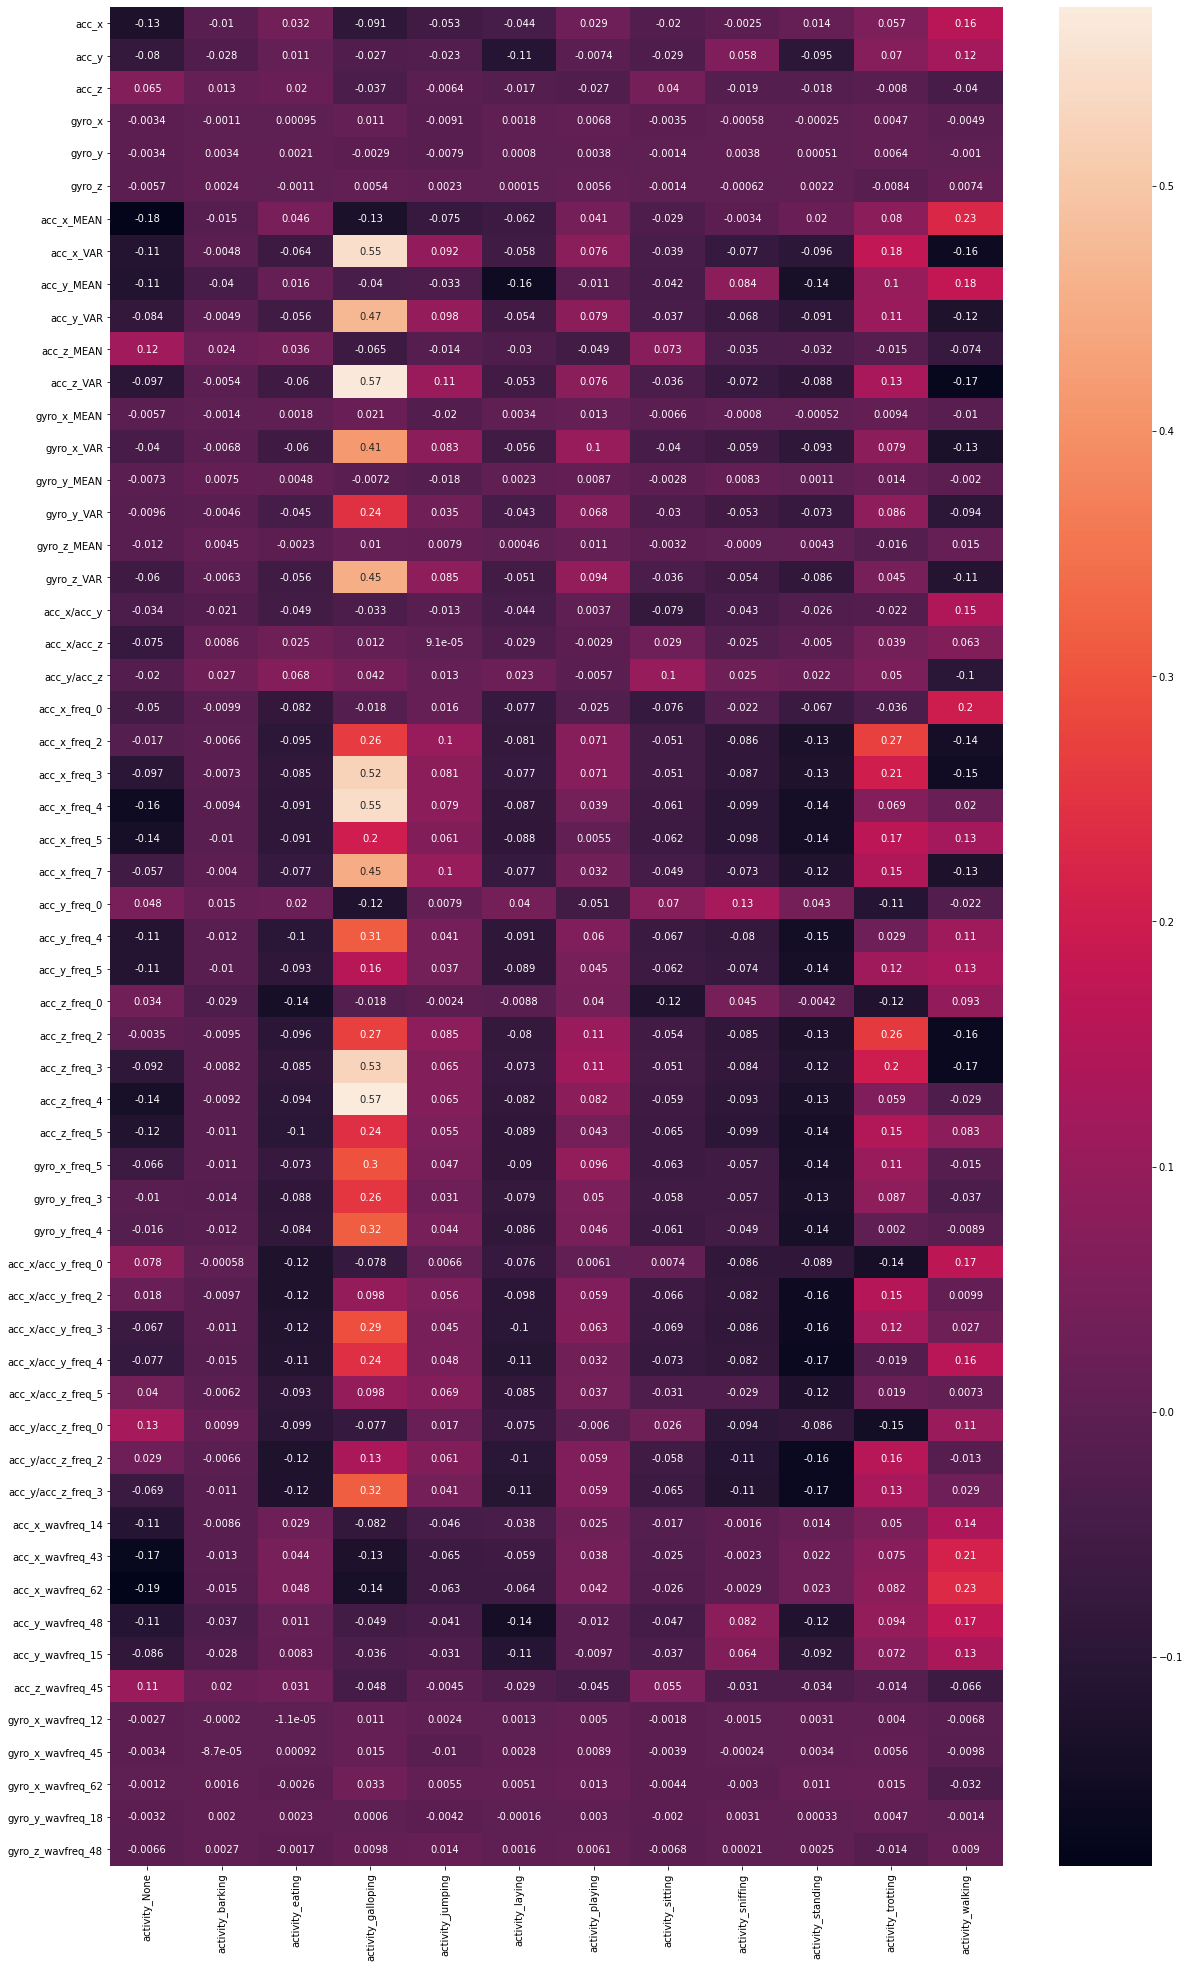

In [29]:
useful_values = [x for x in list(labelledDFList[0].columns) if x not in ['level_0','index','dt','ms_counter','seq_counter','deltaMillis','activity']]
#useful_values = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z", "acc_x/acc_y", "acc_x/acc_z", "acc_y/acc_z"] + composite_variables + fourier_vars + wavelet_vars
plot_corr_matrix(pd.concat(labelledDFList), useful_values)

In [30]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

def split_test_train(data, training_variables, excluded_activities=[], test_ratio=0.25, perform_one_hot=False, undersample=True, oversample=False):
    excluded_activities.append('None')
    new_data = data[~data['activity'].isin(excluded_activities)]
    activities = new_data['activity'].unique()
    print("Activity Data Count:")
    print(new_data['activity'].value_counts())
    print()
    if(undersample):
        print("Undersampling to: " + str(np.min(new_data['activity'].value_counts())) + " data points per activity" )
    elif(oversample):
        print("Oversampling to: " + str(np.max(new_data['activity'].value_counts())) + " data points per activity" )
    independent_data = new_data[training_variables]
    
    one_hot=new_data['activity'].to_numpy()
    print(one_hot)
    if(perform_one_hot):
        one_hot = pd.get_dummies(new_data['activity'])
        if(undersample):
            rus = RandomUnderSampler()
            X_resampled, y_resampled = rus.fit_resample(independent_data.to_numpy(), one_hot.to_numpy())
            #Returns X_train,X_test,y_train,y_test, independent_data.columns, one_hot.columns
            return (train_test_split(X_resampled,y_resampled,test_size=test_ratio), independent_data.columns, one_hot.columns)
        elif(oversample):
            ros = RandomOverSampler()
            X_resampled, y_resampled = ros.fit_resample(independent_data.to_numpy(), one_hot)
            #Returns X_train,X_test,y_train,y_test, independent_data.columns, one_hot.columns
            return (train_test_split(X_resampled,y_resampled,test_size=test_ratio), independent_data.columns, one_hot.columns)
        else:
            return (train_test_split(independent_data.to_numpy(),one_hot.to_numpy(),test_size=test_ratio), independent_data.columns, one_hot.columns)
    else:
        one_hot=new_data['activity'].to_numpy()
        if(undersample):
            rus = RandomUnderSampler()
            X_resampled, y_resampled = rus.fit_resample(independent_data.to_numpy(), one_hot)
            #Returns X_train,X_test,y_train,y_test, independent_data.columns, one_hot.columns
            return (train_test_split(X_resampled,y_resampled,test_size=test_ratio), independent_data.columns, [])
        elif(oversample):
            ros = RandomOverSampler()
            X_resampled, y_resampled = ros.fit_resample(independent_data.to_numpy(), one_hot)
            #Returns X_train,X_test,y_train,y_test, independent_data.columns, one_hot.columns
            return (train_test_split(X_resampled,y_resampled,test_size=test_ratio), independent_data.columns, [])
        else:
            return (train_test_split(independent_data.to_numpy(),one_hot,test_size=test_ratio), independent_data.columns, [])

In [31]:
from sklearn.metrics import confusion_matrix
import time

def train_classifier(classifier, data, columns_to_use, exclude=[], test_fraction=0.25, name = 'Classifier', perform_one_hot=False, test_dataset=None, undersample_train=False, undersample_test = False, oversample_train = False):
    if(test_dataset is not None):
        (X_train,j,y_train,j),variable_columns, one_hot_columns = split_test_train(data, columns_to_use, excluded_activities=exclude, test_ratio=0.01, perform_one_hot=perform_one_hot, undersample=undersample_train, oversample=oversample_train)
        (j,X_test,j,y_test),j, one_hot_test_columns = split_test_train(test_dataset, columns_to_use, excluded_activities=exclude, test_ratio=0.99, perform_one_hot=perform_one_hot, undersample=undersample_test)
    else:
        (X_train,X_test,y_train,y_test),variable_columns, one_hot_columns = split_test_train(data, columns_to_use, excluded_activities=exclude, test_ratio=test_fraction, perform_one_hot=perform_one_hot, undersample=undersample_train, oversample=oversample_train)
        one_hot_test_columns = one_hot_columns
    
    

    # Train classifier
    print("Training " + name + "...")
    start_time = time.time()
    classifier.fit(X_train,y_train)
    end_time = time.time()
    print(name + " Training Complete in " + str(end_time-start_time) + " seconds")
    print()
    
    #"""
    # Conduct testing
    print("Testing...")
    #log_prob = classifier.predict_log_proba(X_test)
    correct_count = 0
    incorrect_count = 0
    predictions = []
    labels = []
    if(perform_one_hot):
        for i in range(0, len(y_test)):
            predict = one_hot_columns[np.argmax([y[1] for y in [x[i] for x in log_prob]])]
            actual = one_hot_test_columns[np.argmax(y_test[i])]
            if(predict == actual):
                correct_count += 1
            else:
                #print("Predicted: " + predict + " : Actual: " + actual)
                incorrect_count += 1
            predictions.append(predict)
            labels.append(actual)
    else:
        labels = y_test
        predictions = classifier.predict(X_test)
        for i in range(0, len(y_test)):
            if(predictions[i] == labels[i]):
                correct_count += 1
            else:
                #print("Predicted: " + predict + " : Actual: " + actual)
                incorrect_count += 1
    # Print test results
    print("Testing Results:")
    print("Correct Classification: " + str(correct_count))
    print("Incorrect Classification: " + str(incorrect_count))
    print("Accuracy: " + str(100*(correct_count/(correct_count+incorrect_count))) + "%")
    
    # Create confusion matrix
    if(perform_one_hot):
        conf_labels = list(set(labels).union(set(predictions)))
        print(conf_labels)
    else:
        conf_labels=np.unique(predictions)
    #conf_labels = ['laying', 'standing', 'sitting', 'eating', 'walking', 'sniffing', 'trotting', 'playing', 'galloping', 'jumping']
    if(len(conf_labels) == 0):
        cm = confusion_matrix(labels, predictions)#, labels=conf_labels)
        print(cm)
    else:
        cm = confusion_matrix(labels, predictions, labels=conf_labels)
    percentageMap = []
    for i in range(0, len(cm)):
        percentageMap.append([])
        sum = np.sum(cm[i])
        for j in range(0, len(cm[i])):
            if(sum != 0):
                percentageMap[i].append( float(cm[i][j])/float(sum))
            else:
                percentageMap[i].append(0)

    # Plot confusion matrix    
    ax1 = sns.heatmap(percentageMap, annot=True, fmt='.2%', xticklabels = conf_labels, yticklabels=conf_labels)
    plt.title("Confusion Matrix of " + name)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.yticks(rotation=0)
    plt.show()
    
    featureImportances = pd.Series(classifier.feature_importances_)#.sort_values(ascending=False)
    
    ax2 = sns.barplot(x=variable_columns, y=featureImportances)
    plt.title("Feature Importance of " + name) 
    plt.xticks(rotation=75)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.show()
    #"""
    print(one_hot_columns)
    return one_hot_columns

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

activities_to_exclude = ['barking', 'jumping']#, 'eating', 'jumping', 'playing', 'standing']

#train_classifier(RandomForestClassifier(n_estimators=10, verbose=0), labelledDFList[1], useful_values, exclude=['barking'], name='Random Forest', test_fraction = 0.3, perform_one_hot=True, test_dataset=labelledDFList[0])
#train_classifier(ExtraTreesClassifier(n_estimators=300, criterion='entropy', min_samples_leaf=40), pd.concat(labelledDFList), useful_values, exclude=['barking'], name='Extra Trees', test_fraction = 0.3, perform_one_hot=True, undersample_train=True, undersample_test = False)
#train_classifier(ExtraTreesClassifier(n_estimators=300, criterion='entropy'), pd.concat(labelledDFList), useful_values, exclude=['barking'], name='Extra Trees', test_fraction = 0.3, perform_one_hot=True, undersample_train=True, undersample_test = False)
#train_classifier(ExtraTreesClassifier(n_estimators=50, criterion='entropy'), pd.concat([labelledDFList[1], labelledDFList[0]]), useful_values, exclude=activities_to_exclude, name='Extra Trees', test_fraction = 0.3, perform_one_hot=True, test_dataset=labelledDFList[2], undersample_train=False, undersample_test = False)
#train_classifier(ExtraTreesClassifier(n_estimators=300, criterion='entropy'), pd.concat([labelledDFList[1], labelledDFList[0]]), useful_values, exclude=activities_to_exclude, name='Extra Trees', test_fraction = 0.3, perform_one_hot=True, test_dataset=labelledDFList[2], undersample_train=False)
#train_classifier(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10), n_estimators = 100), pd.concat([labelledDFList[1], labelledDFList[0]]), useful_values, exclude=activities_to_exclude, name='Ada Boost', test_fraction = 0.3, perform_one_hot=False, test_dataset=labelledDFList[2])

In [33]:
def test_classifier(classifier, variables, test_data, perform_one_hot=True, activity_labels=[], smoothing_window = 10, excluded_activities='None'):
    independent_data = test_data[variables].to_numpy()
    results = test_data['activity']
    
    print("Test Data Activities: ")
    print(results.value_counts())
    
    results_activities = (pd.get_dummies(results)).columns
    results = results.to_numpy()
    
    labels = []
    predictions = []
    if(perform_one_hot):
        log_probs = classifier.predict_log_proba(independent_data)
        for i in range(0, len(independent_data)):
            prediction = activity_labels[np.argmax([y[1] for y in [x[i] for x in log_probs]])]
            predictions.append(prediction)
    else:
        predictions = classifier.predict(independent_data)
    
    smoothed_predictions = []
    for i in range(0, len(predictions)):
        prediction = predictions[i]
        #print("Index " + str(i))
        #print(str((max(0, i-smoothing_window))) + ":" + str(i) + ":-1")
        #print(len(predictions[(i):(max(0, i-smoothing_window)):-1]))
        #print(str(i+1) + ":" + str(min(i+smoothing_window+1, len(predictions))))
        #print(len(predictions[(i+1):min(i+smoothing_window+1, len(predictions))]))
        previous_distribution = get_label_distribution(predictions[(i):(max(0, i-smoothing_window)):-1])
        post_distribution = {}
        if(i != len(predictions)-1):
            post_distibution = get_label_distribution(predictions[(i+1):min(i+smoothing_window+1, len(predictions))])
        
        if(len(previous_distribution.keys()) != 0):
            previous_most_common, previous_commonality = get_most_common(previous_distribution)
        else:
            previous_most_common = 'N/A'
            previous_commonality = 0
            
        if(len(post_distribution.keys()) != 0):
            post_most_common, post_commonality = get_most_common(post_distribution)
        else:
            post_most_common = 'N/A'
            post_commonality = 0
        
        if(prediction == post_most_common or prediction == previous_most_common):
            smoothed_predictions.append(prediction)
        elif(post_commonality >= previous_commonality):
            smoothed_predictions.append(post_most_common)
        elif(post_commonality < previous_commonality):
            smoothed_predictions.append(previous_most_common)
    
    true_activities = []
    final_predictions = []
    
    for i in range(0, len(smoothed_predictions)):
        if(smoothed_predictions[i] in excluded_activities or results[i] in excluded_activities):
            continue
        else:
            true_activities.append(results[i])
            final_predictions.append(smoothed_predictions[i])
    
    conf_labels = list(set(true_activities).union(set(final_predictions)))
    cm = confusion_matrix(true_activities, final_predictions, labels=conf_labels)
    
    percentageMap = []
    for i in range(0, len(cm)):
        percentageMap.append([])
        sum = np.sum(cm[i])
        for j in range(0, len(cm[i])):
            if(sum != 0):
                percentageMap[i].append( float(cm[i][j])/float(sum))
            else:
                percentageMap[i].append(0)
    
    correct_predictions = 0
    incorrect_predictions = 0
    for i in range(0, len(final_predictions)):
        if(final_predictions[i] == true_activities[i]):
            correct_predictions += 1
        else:
            incorrect_predictions += 1
    print(correct_predictions)
    print(incorrect_predictions)
    print("Accuracy: " + str(100*float(correct_predictions)/(correct_predictions + incorrect_predictions)) + "%")
    
    # Plot confusion matrix    
    ax1 = sns.heatmap(percentageMap, annot=True, fmt='.2%', xticklabels = conf_labels, yticklabels=conf_labels)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.yticks(rotation=0)
    plt.show()


def get_label_distribution(window):
    label_distribution = {}
    for i in range(0, len(window)):
        if window[i] in label_distribution:
            label_distribution[window[i]] = label_distribution[window[i]] + ((i**2 - len(window)**2)**2) / (len(window)**4)
        else:
            label_distribution[window[i]] = ((i**2 - len(window)**2)**2) / (len(window)**4)
    return label_distribution

def get_most_common(distribution):
    common_activity = ''
    value = 0
    for activity in distribution:
        if(distribution[activity] > value):
            common_activity = activity
            value = distribution[activity]
    return common_activity, value

In [34]:
activities_to_exclude = ['barking', 'jumping', 'playing']

#trees_classifier = ExtraTreesClassifier(n_estimators=300, criterion='entropy')
#trees_classifier.get_params()
#variable_columns = train_classifier(trees_classifier, pd.concat(labelledDFList), useful_values, exclude=activities_to_exclude, name='Extra Trees', test_fraction = 0.3, perform_one_hot=True, undersample_train=True, undersample_test = False)
#test_classifier(trees_classifier, useful_values, pd.concat(labelledDFList), activity_labels=variable_columns, excluded_activities=activities_to_exclude)

In [35]:
from sklearn.model_selection import GridSearchCV

class Scorer:
    def __init__(self, test_data, one_hot, variables, activity_labels, excluded_activities):
        self.test_data = test_data
        self.one_hot = one_hot
        self.variables = variables
        self.activity_labels = activity_labels
        self.excluded_activities = excluded_activities

    def __call__(self, classifier, X, y):
        smoothing_window = 10
        
        independent_data = self.test_data[self.variables].to_numpy()
        results = self.test_data['activity']

        results_activities = (pd.get_dummies(results)).columns
        results = results.to_numpy()

        labels = []
        predictions = []
        if(self.one_hot):
            log_probs = classifier.predict_log_proba(independent_data)
            for i in range(0, len(independent_data)):
                prediction = self.activity_labels[np.argmax([d[1] for d in [x[i] for x in log_probs]])]
                predictions.append(prediction)
        else:
            predictions = classifier.predict(independent_data)

        smoothed_predictions = []
        for i in range(0, len(predictions)):
            prediction = predictions[i]
            #print("Index " + str(i))
            #print(str((max(0, i-smoothing_window))) + ":" + str(i) + ":-1")
            #print(len(predictions[(i):(max(0, i-smoothing_window)):-1]))
            #print(str(i+1) + ":" + str(min(i+smoothing_window+1, len(predictions))))
            #print(len(predictions[(i+1):min(i+smoothing_window+1, len(predictions))]))
            previous_distribution = get_label_distribution(predictions[(i):(max(0, i-smoothing_window)):-1])
            post_distribution = {}
            if(i != len(predictions)-1):
                post_distibution = get_label_distribution(predictions[(i+1):min(i+smoothing_window+1, len(predictions))])

            if(len(previous_distribution.keys()) != 0):
                previous_most_common, previous_commonality = get_most_common(previous_distribution)
            else:
                previous_most_common = 'N/A'
                previous_commonality = 0

            if(len(post_distribution.keys()) != 0):
                post_most_common, post_commonality = get_most_common(post_distribution)
            else:
                post_most_common = 'N/A'
                post_commonality = 0

            if(prediction == post_most_common or prediction == previous_most_common):
                smoothed_predictions.append(prediction)
            elif(post_commonality >= previous_commonality):
                smoothed_predictions.append(post_most_common)
            elif(post_commonality < previous_commonality):
                smoothed_predictions.append(previous_most_common)

        true_activities = []
        final_predictions = []
        
        correct_predictions = 0
        incorrect_predictions = 0

        for i in range(0, len(smoothed_predictions)):
            if(smoothed_predictions[i] in self.excluded_activities or results[i] in self.excluded_activities):
                continue
            else:
                true_activities.append(results[i])
                final_predictions.append(smoothed_predictions[i])
                if(results[i] == smoothed_predictions[i]):
                    correct_predictions += 1
                else:
                    incorrect_predictions += 1
        
        if(incorrect_predictions + correct_predictions == 0):
            return 0
        
        print("Score: " + str(float(correct_predictions)/float(correct_predictions + incorrect_predictions)))
        return float(correct_predictions)/float(correct_predictions + incorrect_predictions)

def perform_grid_search(classifier, training_data, test_data, columns_to_use, params, one_hot=True, excluded_activities=[], undersample=False):
    (X_train,j,y_train,j),variable_columns, one_hot_columns = split_test_train(training_data, columns_to_use, excluded_activities=excluded_activities, test_ratio=0.01, perform_one_hot=one_hot, undersample=undersample)
    grid = GridSearchCV(classifier, params, scoring=Scorer(test_data, one_hot, columns_to_use, one_hot_columns, excluded_activities), cv = 2)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    return grid

In [36]:
#params = {'criterion': ['entropy', 'gini'], 'max_depth':[None, 3, 6, 10, 15], 'n_estimators': [50, 100, 300, 500]}
#params = {'criterion': ['entropy'], 'max_depth':[None], 'n_estimators': [300, 600], 'min_samples_leaf':[40], 'min_samples_split':[110], 'n_jobs':[-1]}

#grid = perform_grid_search(ExtraTreesClassifier(), pd.concat([labelledDFList[1], labelledDFList[2], labelledDFList[3]]), labelledDFList[0], useful_values, params, excluded_activities=activities_to_exclude)

In [37]:
activities_to_exclude = ['barking', 'jumping', 'playing', 'sleeping']
trees_classifier = ExtraTreesClassifier(n_estimators=600, criterion='entropy', verbose=2)#, min_samples_split=110, n_jobs=-1)
trees_classifier.get_params()
variable_columns = train_classifier(trees_classifier, pd.concat(labelledDFList[0:4]), useful_values, exclude=activities_to_exclude, name='Extra Trees', test_fraction = 0.3, perform_one_hot=False, undersample_train=False, undersample_test = False, oversample_train=True)
test_classifier(trees_classifier, useful_values, labelledDFList[4], activity_labels=variable_columns, excluded_activities=activities_to_exclude, perform_one_hot=False)

Activity Data Count:
walking      118562
trotting      34848
galloping     24297
standing      18453
sniffing      12757
eating        10238
laying         4956
sitting        3326
Name: activity, dtype: int64

Oversampling to: 118562 data points per activity
['galloping' 'galloping' 'galloping' ... 'eating' 'eating' 'eating']
Training Extra Trees...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 600


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


building tree 2 of 600
building tree 3 of 600
building tree 4 of 600
building tree 5 of 600
building tree 6 of 600
building tree 7 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

activities_to_exclude = ['barking', 'jumping', 'playing', 'sleeping']
trees_classifier = GradientBoostingClassifier(n_estimators=50, verbose=2)#, min_samples_split=110, n_jobs=-1)
variable_columns = train_classifier(trees_classifier, pd.concat(labelledDFList[0:4]), useful_values, exclude=activities_to_exclude, name='SKLearn Grad. Boosting Classifier', test_fraction = 0.3, perform_one_hot=False, undersample_train=False, undersample_test = False, oversample_train=True)
test_classifier(trees_classifier, useful_values, labelledDFList[4], activity_labels=variable_columns, excluded_activities=activities_to_exclude, perform_one_hot=False)

Activity Data Count:
walking      118562
trotting      34848
galloping     24297
standing      18453
sniffing      12757
eating        10238
laying         4956
sitting        3326
Name: activity, dtype: int64

Oversampling to: 118562 data points per activity
['galloping' 'galloping' 'galloping' ... 'eating' 'eating' 'eating']
Training SKLearn Grad. Boosting Classifier...
      Iter       Train Loss   Remaining Time 
         1           1.7356          115.38m


In [ ]:
import xgboost as xgb

activities_to_exclude = ['barking', 'jumping', 'playing', 'sleeping']
trees_classifier = xgb.XGBClassifier(objective='multi:softmax', n_estimators=50, verbosity=2, max_depth=10)#ExtraTreesClassifier(n_estimators=600, criterion='entropy', verbose=2)#, min_samples_split=110, n_jobs=-1)
variable_columns = train_classifier(trees_classifier, pd.concat(labelledDFList[0:4]), useful_values, exclude=activities_to_exclude, name='XGBoost', test_fraction = 0.3, perform_one_hot=False, undersample_train=False, undersample_test = False, oversample_train=True)
test_classifier(trees_classifier, useful_values, labelledDFList[4], activity_labels=variable_columns, excluded_activities=activities_to_exclude, perform_one_hot=False)